In [123]:
# import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline


from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [124]:
# Test for the set n.2
dataset = pd.read_csv('/home/developer/Downloads/IMS/2nd_test/2004.02.12.10.32.39', sep='\t')
dataset.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
dataset.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,-0.042,-0.073,-0.007,-0.105
1,0.015,0.000,0.007,0.000
2,-0.051,0.020,-0.002,0.100
3,-0.107,0.010,0.127,0.054
4,-0.078,-0.212,0.042,-0.044


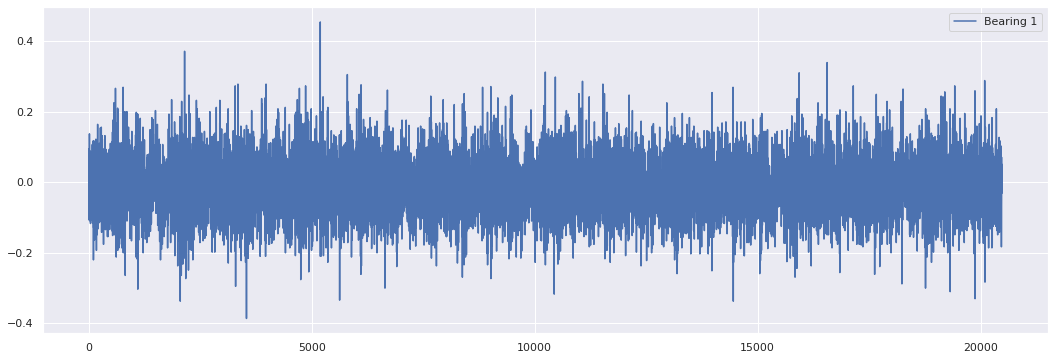

In [125]:
# raw signal
dataset[['Bearing 1']].plot(figsize=(18,6));

In [126]:
# set random seed
seed(10)
tf.random.set_seed(10)

In [127]:
# Mechanical degradation in the bearings occurs gradually over time.
# We use one datapoint every 10 minutes in the analysis. 
# Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints in each file.

# load, average and merge sensor samples
data_dir = "/home/developer/Downloads/IMS/2nd_test"
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [128]:
# transform data file index to datetime and sort in chronological order
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()


Dataset shape: (984, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [129]:
# Train/ test data
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


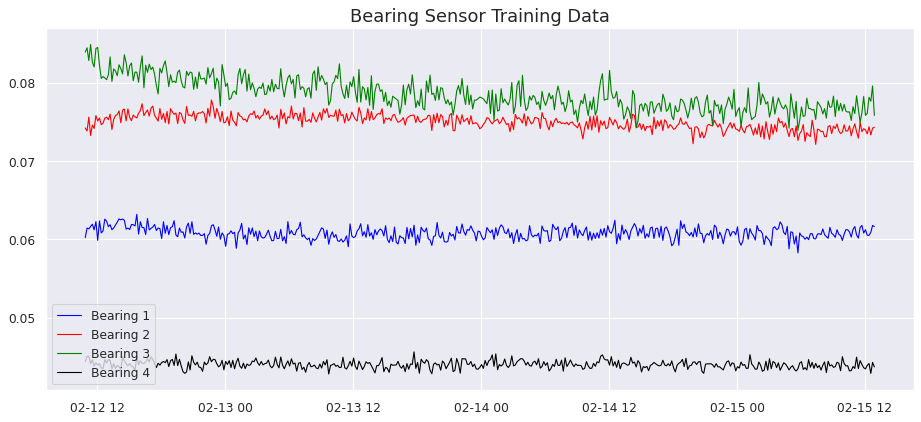

In [130]:
# Plot bearing merged value
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

In [131]:
# Using discrete Fourier transform we get a different view of the data from the time domain to the frequency domain
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

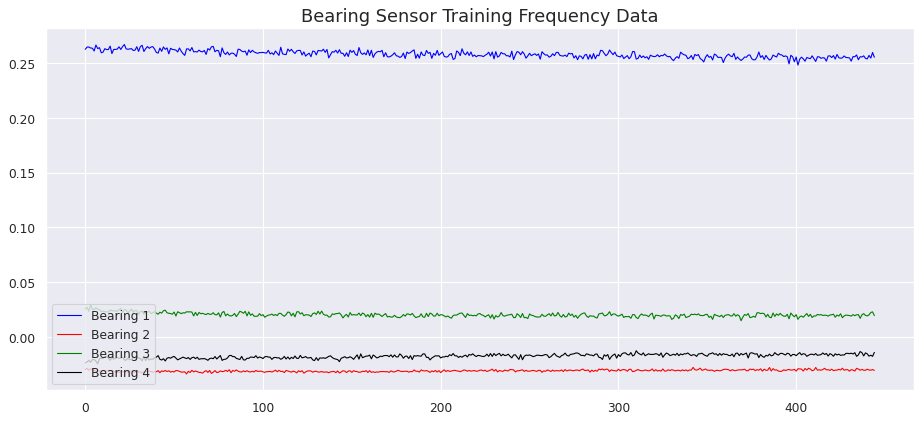

In [132]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

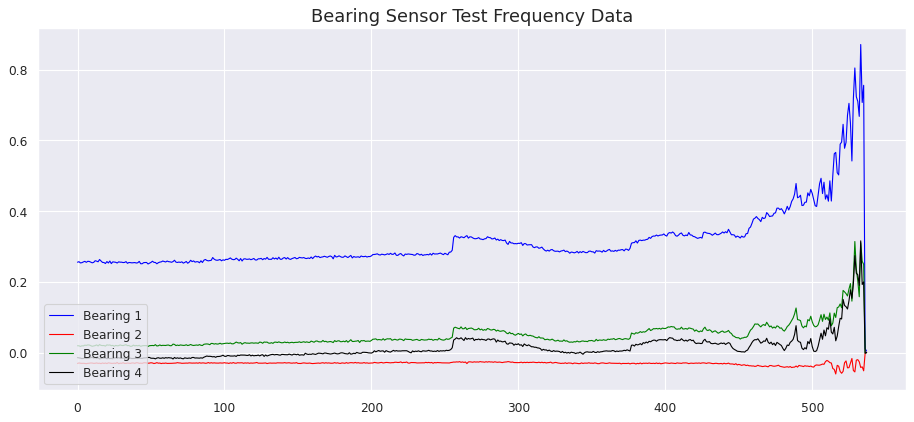

In [133]:
# frequencies of the degrading sensor signal, at the end failure occurred in bearing 1
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [134]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [135]:
X_train

array([[0.39518051, 0.36851684, 0.91295856, 0.56833449],
       [0.64304579, 0.30094449, 0.96148238, 0.79465028],
       [0.62379364, 0.61266227, 0.81348964, 0.80775623],
       ...,
       [0.53419516, 0.21178246, 0.33869465, 0.02647161],
       [0.71083045, 0.36463536, 0.51749078, 0.52396122],
       [0.68310894, 0.38704446, 0.17330254, 0.32004848]])

In [136]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)



Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [137]:
X_train

array([[[0.39518051, 0.36851684, 0.91295856, 0.56833449]],

       [[0.64304579, 0.30094449, 0.96148238, 0.79465028]],

       [[0.62379364, 0.61266227, 0.81348964, 0.80775623]],

       ...,

       [[0.53419516, 0.21178246, 0.33869465, 0.02647161]],

       [[0.71083045, 0.36463536, 0.51749078, 0.52396122]],

       [[0.68310894, 0.38704446, 0.17330254, 0.32004848]]])

In [138]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model



In [139]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 16)             1344      
                                                                 
 lstm_17 (LSTM)              (None, 4)                 336       
                                                                 
 repeat_vector_4 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_19 (LSTM)              (None, 1, 16)             1344      
                                                           

In [140]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history



Epoch 1/100
43/43 [==============================] - 6s 20ms/step - loss: 0.4454 - val_loss: 0.3190
Epoch 2/100
43/43 [==============================] - 0s 8ms/step - loss: 0.3812 - val_loss: 0.2455
Epoch 3/100
43/43 [==============================] - 0s 10ms/step - loss: 0.2909 - val_loss: 0.1621
Epoch 4/100
43/43 [==============================] - 0s 9ms/step - loss: 0.1621 - val_loss: 0.1684
Epoch 5/100
43/43 [==============================] - 0s 7ms/step - loss: 0.1152 - val_loss: 0.1404
Epoch 6/100
43/43 [==============================] - 0s 8ms/step - loss: 0.1073 - val_loss: 0.1225
Epoch 7/100
43/43 [==============================] - 0s 7ms/step - loss: 0.1035 - val_loss: 0.1146
Epoch 8/100
43/43 [==============================] - 0s 7ms/step - loss: 0.1019 - val_loss: 0.1138
Epoch 9/100
43/43 [==============================] - 0s 8ms/step - loss: 0.1013 - val_loss: 0.1151
Epoch 10/100
43/43 [==============================] - 0s 9ms/step - loss: 0.1011 - val_loss: 0.1132
Epoch 1

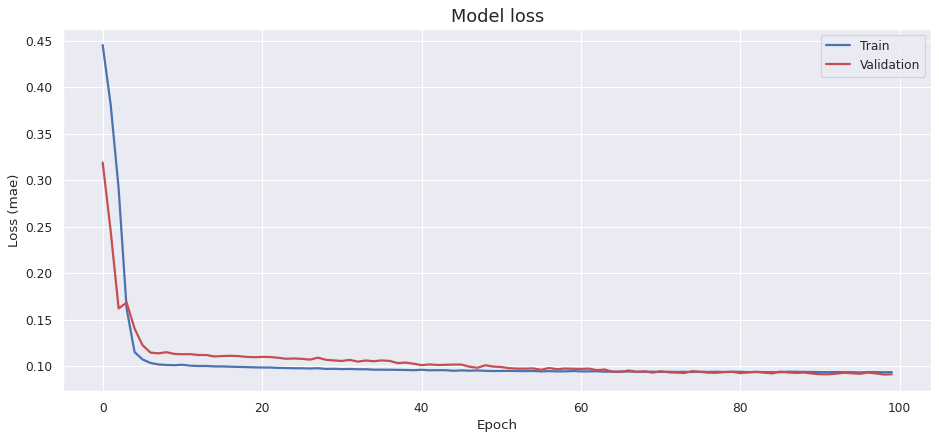

In [141]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

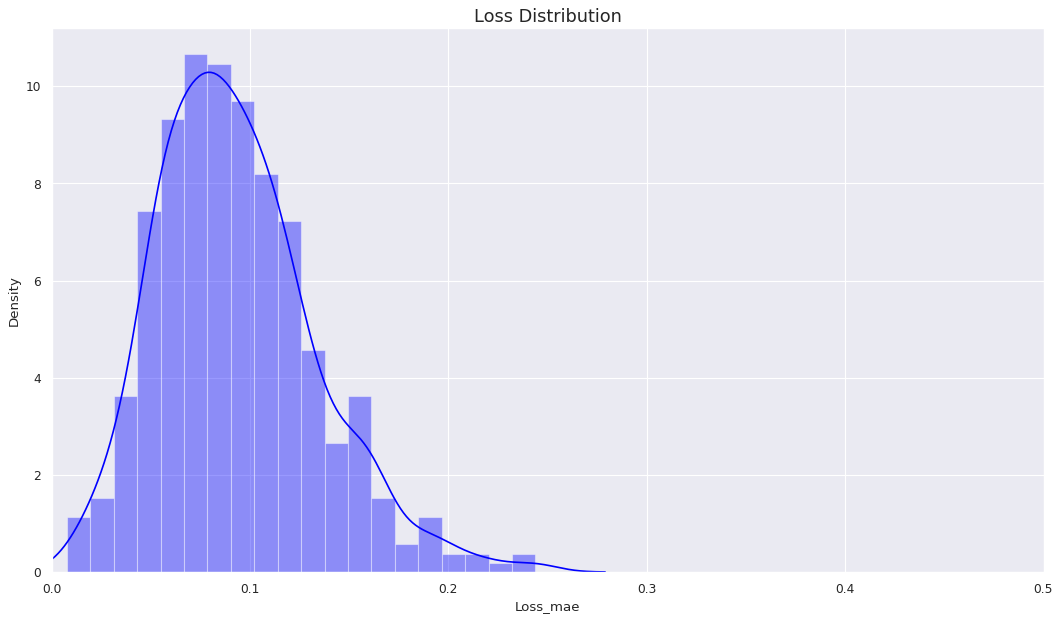

In [142]:
# Distribution of Loss Function

# By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly.


# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])



In [143]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()


,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.094599,0.275,False
2004-02-15 13:02:39,0.171154,0.275,False
2004-02-15 13:12:39,0.068413,0.275,False
2004-02-15 13:22:39,0.052943,0.275,False
2004-02-15 13:32:39,0.039029,0.275,False


In [144]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

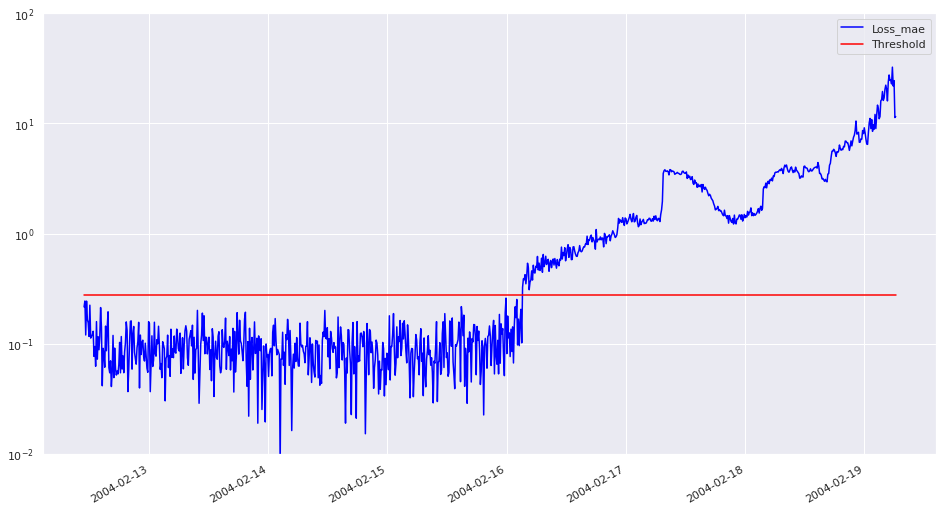

In [145]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])